# Note the following 15 convolutional layer unet architecture was given to us through the Deep Learning Course at Johns Hopkins University.  
### Specifically class unet(nn.module), def add_conv_state(), def upsample()

### The rest of the code is self made

<br>
<br>
<br>

def add_conv_layer() adds a 'unit' made up of 2 convolutional layers that go through a BatchNorm and LeakyReLU layer.

class unet() downsamples with 4 of these 'units' using various channel dimensions. Then it upsamples with another 3 of these 'units'.  This is done while concatenating (feed forwarding) the corresponding layer from the downsampling process. The final layer reduces the output to 8 tool classes. 


# CODE

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import glob
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision import transforms
import random

precision = 4
torch.set_printoptions(precision,sci_mode=False)
np.set_printoptions(precision)

device = torch.device("cuda:0")
dtype_numpy = np.float64
dtype_torch = torch.float64

In [2]:
%%capture
# importing data from drive
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/My\ Drive/Colab_Notebooks/Data/DeepLearning_fa19_hw6_prob1.zip;

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:
4/1AY0e-g7kZUeJ2V623u1ekpuv4zrVc7z0UdZauohtA2ZgUR2q5yf5grJKmNU


In [23]:
# code to visualize one hot encoded numpy array (for debugging)
def plot_onehot(x):
  """
  takes array x with dimensions (# classes, image height, image width)
  and plots it with plt.imshow()
  """
  indices = np.argmax(x,0)
  plt.imshow(indices, cmap='Pastel1',vmin=0,vmax=7)

In [31]:
# Dataset Creation Class
# in general, mask = target
class ImageDataset(Dataset):
    def __init__(self,input_dir,mode = 'none',transform=False):
      self.mode = mode
      self.transform_bool = transform
      if self.mode == 'dice':
        self.image_pathlist = glob.glob(input_dir + '/*/*_input.jpg')
        self.mask_pathlist = glob.glob(input_dir + '/*/*_mask.png')
      else:
        self.image_pathlist = glob.glob(input_dir + '/*/*_gray.jpg')
        self.mask_pathlist = glob.glob(input_dir + '/*/*_input.jpg')

    def __len__ (self):
      return len(self.image_pathlist)

    def transform(self,im,mask):
      if random.random() > 0.5:
        im = transforms.functional.hflip(im)
        mask = transforms.functional.hflip(mask)
      if random.random() > 0.5:  
        im = transforms.functional.vflip(im)
        mask = transforms.functional.vflip(mask)        
      return im, mask

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
        idx = idx.tolist()

      # opens image files with shape (channels, image height, image width)
      im = Image.open(self.image_pathlist[idx])
      # opens mask files with shape (channels, image height, image width)
      mask = Image.open(self.mask_pathlist[idx])

      if self.transform_bool:
        im, mask = self.transform(im, mask)

      im = ToTensor()(im)
      mask = ToTensor()(mask)

      # initializes one hot encoded array for dice loss
      # shape (num_classes, image height, image width)
      if self.mode =='dice':
        # rounds the mask pixel values to whole numbers, 255/32 derived from mapping file
        mask = torch.round(mask*255/32)
        target = torch.zeros([8,mask.size()[1],mask.size()[2]],dtype=float)
        # assigns a class label for each unique pixel value in mask
        for i in range(num_classes):
          # create True and False boolean array 'indices' of size (image height, image width)
          # squeeze mask because its in shape (1, image height, image width)
          indices = (mask.squeeze() == i)
          target[i,indices] = 1
      # just have labels be the given label input 
      # mode 'color' should use this
      else:
        target = mask

      item = {'image': im, 'mask': target}
      return item

In [32]:
# Functions for adding the convolution layer
def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
  if useBN:
    # Use batch normalization
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1)
    )
  else:
    # No batch normalization
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU(),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU()
    )

In [33]:
# Upsampling

def upsample(ch_coarse, ch_fine):
  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
    nn.ReLU()
  )

In [34]:
# diceloss cell
class DICELoss(nn.Module):
  def __init__(self):
    super(DICELoss, self).__init__()
    # smoothing
    self.smooth = 1
  
  def forward(self, output_array, target_array):
    # extracts batch_size from first dimension of target array
    batch_size = target_array.size()[0]

    # flattens output array and target array so that there is one
    # flattened vector for each example in the batch and each class
    output_flat = output_array.view(batch_size,num_classes,-1)
    target_flat = target_array.view(batch_size,num_classes,-1)

    # calculates intersection between output and target. It will be higher if 
    # probability in output vector is larger for the nonzero value in target one
    # hot encoded vector
    intersection = torch.sum(output_flat * target_flat, dim=(0,2))

    
    # loss is caculated as 1 - dice score
    # per class and example, the dice score is 2 * intersection = smoothing constant / (sum of individual
    # sets + smoothing constant)
    # smoothing is implemented for cases where certain classes do not show up in the image
    # the dice_score below is an array of size (batch_size, num_classes)
    numerator = 2. * intersection + self.smooth
    denominator = torch.sum(output_flat,dim=(0,2)) + torch.sum(target_flat,dim=(0,2)) + self.smooth
    dice_score = numerator / denominator
    # print(dice_score)

    # we then take the mean over all classes
    dice_score = torch.mean(dice_score)

    loss = 1 - dice_score
    return loss

In [35]:
# unet cell
# U-Net
class unet(nn.Module):
  def __init__(self, useBN=False):
    super(unet, self).__init__()
    # Downgrade stages
    self.conv1 = add_conv_stage(3, 32, useBN=useBN)
    self.conv2 = add_conv_stage(32, 64, useBN=useBN)
    self.conv3 = add_conv_stage(64, 128, useBN=useBN)
    self.conv4 = add_conv_stage(128, 256, useBN=useBN)
    # Upgrade stages
    self.conv3m = add_conv_stage(256, 128, useBN=useBN)
    self.conv2m = add_conv_stage(128,  64, useBN=useBN)
    self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
    # Maxpool
    self.max_pool = nn.MaxPool2d(2)
    # Upsample layers
    self.upsample43 = upsample(256, 128)
    self.upsample32 = upsample(128,  64)
    self.upsample21 = upsample(64 ,  32)
    # final layer
    self.conv5 = nn.Conv2d(32,8,kernel_size=1,stride=1,padding=0,bias=True)
    # weight initialization
    # You can have your own weight intialization. This is just an example.
    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        m.reset_parameters()
        #torch.nn.init.xavier_normal_(m.weight.data) # bad
        #torch.nn.init.xavier_uniform_(m.weight.data) # bad
        torch.nn.init.kaiming_normal_(m.weight.data) # not as bad, can be spotty
        #torch.nn.init.normal_(m.weight.data) # bad
        #torch.nn.init.kaiming_uniform_(m.weight.data) # bad, very spotty
        if m.bias is not None:
          m.bias.data.zero_()

  def forward(self, x):
    conv1_out = self.conv1(x)
    conv2_out = self.conv2(self.max_pool(conv1_out))
    conv3_out = self.conv3(self.max_pool(conv2_out))
    conv4_out = self.conv4(self.max_pool(conv3_out))

    conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
    conv3m_out  = self.conv3m(conv4m_out_)

    conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
    conv2m_out  = self.conv2m(conv3m_out_)

    conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
    conv1m_out  = self.conv1m(conv2m_out_)
    # final 1 x 1 convolutional layer with softmax activation
    convfinal_out = functional.softmax(self.conv5(conv1m_out), dim=1)
    # convfinal_out = functional.leaky_relu(self.conv5(conv1m_out), negative_slope=0.1)
    #convfinal_out = torch.sigmoid(self.conv5(conv1m_out))

    return convfinal_out

In [45]:
def experiment_main_1c(iteration,num_example,seed_index,num_epoch,learning_rate):
  # experiment cell
  # problem 1a
  # hyperparameters
  learning_rate = learning_rate
  num_epoch =  num_epoch

  torch.manual_seed(seed_index+iteration)
  num_steps_per_val = 20

  model = unet(useBN=True)

  model.cuda()
  optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

  info = []

  # ImageDataset Objects
  image_dataset = ImageDataset(input_dir = 'DeepLearning_fa19_HW6_Prob1/HW6_data/segmentation/train', mode='dice',transform=True)
  val_dataset = ImageDataset(input_dir = 'DeepLearning_fa19_HW6_Prob1/HW6_data/segmentation/validation',mode = 'dice',transform=True)

  # dataloader objects and enumerate for train and test datasets
  dataloader_train = DataLoader(image_dataset, batch_size = train_batch_size, shuffle=True)
  # dataloader_train_iterator = enumerate(dataloader_train)

  dataloader_validation = DataLoader(val_dataset, batch_size = validation_batch_size, shuffle=True)
  # dataloader_validation_iterator = enumerate(dataloader_validation)

  best_val_err = 1.0
  fig, ax = plt.subplots(2, 1, sharex=True)

  print("Start Training...Seed", seed_index+ iteration,'...lr: ',learning_rate)
  convergence_counter = 0
  for epoch in range(num_epoch):
    ########################### Training #####################################
    model.train()

    dataloader_train_iterator = enumerate(dataloader_train)
    i_batch,item_batch = next(dataloader_train_iterator)
    input_batch = item_batch['image'].cuda()
    label_batch = item_batch['mask'].cuda()

    output_batch = model(input_batch)

    # unit tested label_batch is the one hot encoded array mask/label
    # plot_onehot(label_batch[0].cpu().detach().numpy())

    # Compute loss (and error rate).
    loss_fn = DICELoss()
    loss = loss_fn(output_batch, label_batch)  
    train_loss = loss.item()

    # resets gradients and does backpropagation to find gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    # converts tensors to numpy arrays for computation to reduce CUDA memory usage
    output_batch = output_batch.cpu().detach().numpy()
    label_batch = label_batch.float().cpu().detach().numpy()

    # output_batch is shape (batch_size, #classes, image size tuple) 
    # every value is the probability of the class for that example for a certain pixel
    output_batch_indices = np.argmax(output_batch,axis = 1)
    # output_batch_indices is of shape (batch_size,image size tuple)
    # label_batch is a one hot encoded tensor of shape (batch_size,#classes, image size tuple)
    # a correct match would then be output_batch_indices == max(label_batch in the class dimen)

    train_err = 1.0 - (output_batch_indices == np.argmax(label_batch,axis=1)).mean()
    

    ########################### Validation #####################################
    if epoch % num_steps_per_val == 0:
      with torch.no_grad():
        # print("\nEPOCH " +str(epoch+1)+" of "+str(num_epoch)+"\n")
        model.eval()

        dataloader_validation_iterator = enumerate(dataloader_validation)
        i_batch,item_batch = next(dataloader_validation_iterator)
        input_batch = item_batch['image'].cuda()
        label_batch = item_batch['mask'].cuda()
        output_batch = model(input_batch)
        
        # computes loss using dice loss
        loss_fn = DICELoss()
        loss = loss_fn(output_batch, label_batch)  
        val_loss = loss.item()

        # converts tensors to numpy arrays for computation to reduce CUDA memory usage
        output_batch = output_batch.cpu().detach().numpy()
        output_batch_indices = np.argmax(output_batch,axis = 1)
        label_batch = label_batch.float().cpu().detach().numpy()
        
        # computes error rate by comparing predicted class and true class for all batch examples
        val_err = 1.0 - (output_batch_indices == np.argmax(label_batch,axis=1)).mean()

        if val_err < best_val_err:
              best_val_err = val_err
              print('Step {:5d}: Obtained a best validation error of {:.3f}.'.format(epoch, best_val_err))
              convergence_counter = 0
        else:
              convergence_counter +=1
              # if convergence_counter > number of validation checks
              if convergence_counter > 50:
                print('stopped training on epoch: ', epoch)
                break

        # plotting
        info.append([epoch, train_loss, val_loss, train_err, val_err])
        x, y11, y12, y21, y22 = zip(*info)
        ax[0].plot(x, y11, x, y12)
        ax[0].legend(['Train loss', 'Val loss'])
        ax[1].plot(x, y21, x, y22)
        ax[1].legend(['Train err', 'Val err'])
        # ax[2].plot(x[1:],y21[1:],x[1:],y22[1:])
        # ax[2].legend(['Train err skip first iteration','Val err skip first iteration'])
  plt.show()
  torch.save(model.state_dict(), 'unet_color.pth')
  # test performance

  with torch.no_grad():
    test_dataset = ImageDataset(input_dir = 'DeepLearning_fa19_HW6_Prob1/HW6_data/segmentation/test', mode='dice')
    dataloader_test = DataLoader(test_dataset, batch_size = 10, shuffle=True) # 49 because of 49 test images

    dataloader_test_iterator = enumerate(dataloader_test)
    _,batch_data = next(dataloader_test_iterator)

    input_batch = batch_data['image'].cuda()
    label_batch = batch_data['mask'].cuda()

    output_batch = model(input_batch)

    output_batch = output_batch.cpu().detach().numpy()
    output_batch_indices = np.argmax(output_batch,axis = 1)

    fig = plt.figure()
    fig.set_figheight(5*2)
    fig.set_figwidth(5*num_example)
    offset = 7
    for i in range(num_example):
      plt.subplot(3,num_example,i+1)
      plot_onehot(output_batch[i,:,:,:])
      plt.subplot(3,num_example,i+num_example+1)
      plot_onehot(label_batch[i,:,:,:].cpu().detach().numpy())
      # code to check if raw images are right
      plt.subplot(3,num_example,i+2*num_example+1)
      plt.imshow(input_batch[i].cpu().detach().numpy().transpose((1,2,0)))
    plt.show()


    # computes error rate by comparing predicted class and true class for all batch examples
    test_err = 1.0 - (output_batch_indices == np.argmax(label_batch.float().cpu().detach().numpy(),axis=1)).mean()

    print("test accuracy: %0.4f" %(1-test_err))

# RESULTS (top row predictions, middle row true labels/masks, bottom row raw images)

Start Training...Seed 1737 ...lr:  0.001
Step     0: Obtained a best validation error of 0.767.
Step    20: Obtained a best validation error of 0.233.
Step    40: Obtained a best validation error of 0.189.
Step    60: Obtained a best validation error of 0.143.
Step    80: Obtained a best validation error of 0.110.
Step   100: Obtained a best validation error of 0.104.
Step   140: Obtained a best validation error of 0.097.
Step   160: Obtained a best validation error of 0.087.
Step   180: Obtained a best validation error of 0.086.
Step   200: Obtained a best validation error of 0.079.


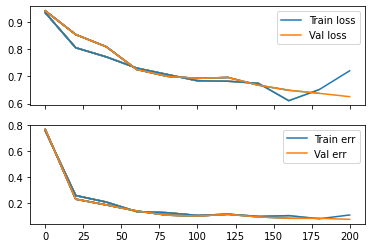

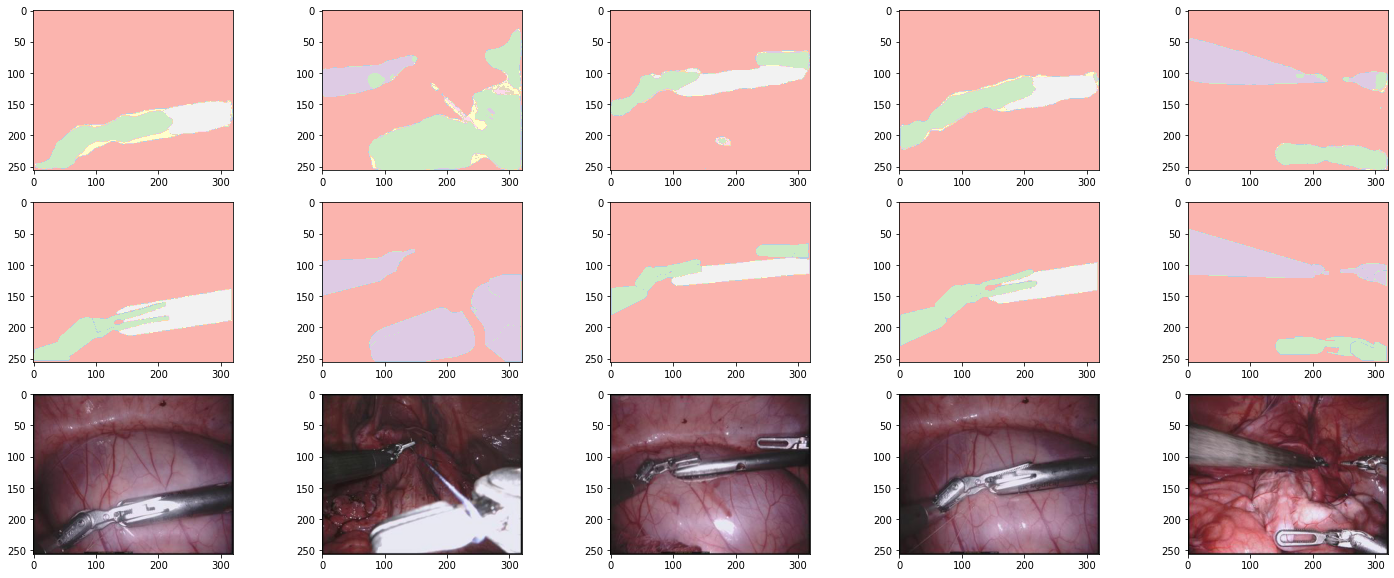

test accuracy: 0.9221


In [48]:
# variables
num_classes = 8
train_batch_size = 10
validation_batch_size= 50
seed_index = 1737
num_seed =  1
num_example = 5
# max epochs
num_epoch = 201
learning_rate_list = [.001]
for i in range(num_seed):
  for k in range(len(learning_rate_list)):
    experiment_main_1c(iteration=i,num_example=num_example,seed_index=seed_index,num_epoch=num_epoch,learning_rate = learning_rate_list[k])